<a href="https://colab.research.google.com/github/aruaru0/pytorch-tests/blob/main/Psudo_Labeling_entropy_test_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

# 簡単なCNNモデルをMNISTの手書き文字を使って学習させる

In [2]:
train_dataset = torchvision.datasets.MNIST(root="data",
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)
valid_dataset = torchvision.datasets.MNIST(root="data",
                                           train=False,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17379101.31it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 491612.16it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 943143.53it/s] 


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9886107.30it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



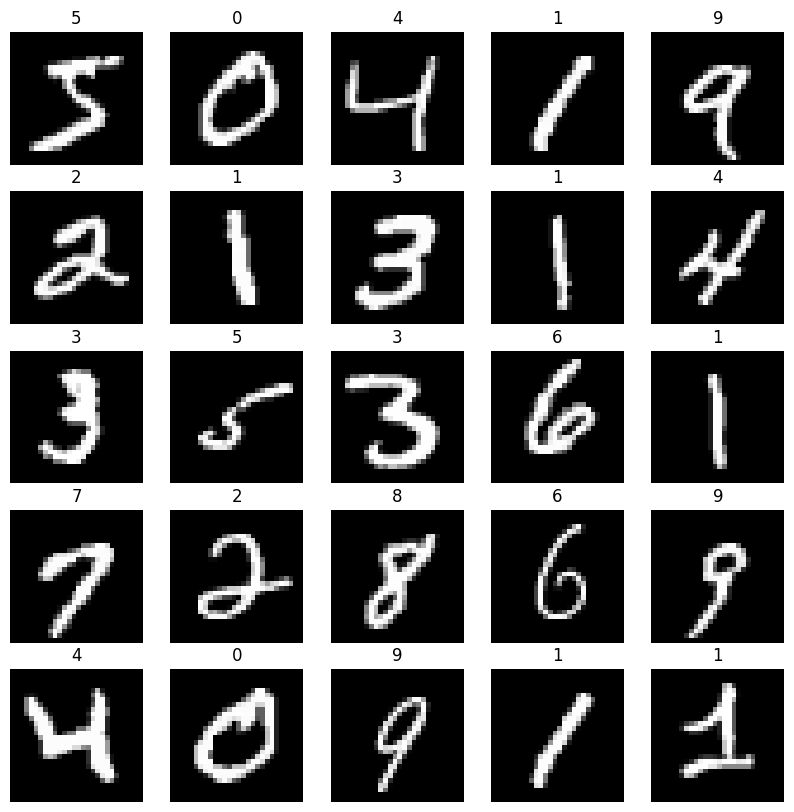

In [3]:
# データを確認
fig, ax = plt.subplots(5,5, figsize=(10,10))

for i in range(25) :
  img, label = train_dataset[i]
  r, c = i//5, i%5
  ax[r, c].imshow(img.squeeze(), cmap="gray")
  ax[r, c].axis("off")
  ax[r, c].set_title(label)

In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class MyCNNModel(nn.Module):
  def __init__(self, input_size):
    super(MyCNNModel, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.act = nn.ReLU()
    self.pool2 = nn.AdaptiveAvgPool1d(1024)
    self.fc1 = nn.Linear(1024, 256)
    self.fc2 = nn.Linear(256, 10)
  def forward(self, x):
    x = self.pool(self.act(self.conv1(x)))
    x = self.pool(self.act(self.conv2(x)))
    x = torch.flatten(x, start_dim=1)
    x = self.pool2(x)
    x = self.act(self.fc1(x))
    x = self.fc2(x)
    return x


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyCNNModel(28).to(device)
model

MyCNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act): ReLU()
  (pool2): AdaptiveAvgPool1d(output_size=1024)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
def do_train(model, device, loader, criterion, optimizer):
  model.train()
  tot_loss = 0.0
  tot_score = 0.0
  for images, labels in tqdm(loader, desc="train"):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    tot_loss += loss.detach().item()
    tot_score += accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())

  tot_loss /= len(loader)
  tot_score /= len(loader)
  return tot_loss, tot_score

In [9]:
def do_valid(model, device, loader, criterion):
  model.eval()
  tot_loss = 0.0
  tot_score = 0.0
  with torch.no_grad():
    for images, labels in tqdm(loader, desc="valid"):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      tot_loss += loss.detach().item()
      tot_score += accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())
  tot_loss /= len(loader)
  tot_score /= len(loader)
  return tot_loss, tot_score

In [10]:
num_epochs = 20
for epoch in range(num_epochs):
  print(f'[EPOCH {epoch+1}]')
  train_loss, train_acc = do_train(model, device, train_loader, criterion, optimizer)
  valid_loss, valid_acc = do_valid(model, device, valid_loader, criterion)
  print(f"--> train loss {train_loss}, train accuracy {train_acc}, valid loss {valid_loss} valid accuracy {valid_acc}")

[EPOCH 1]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.2730338871896045, train accuracy 0.9183602078891258, valid loss 0.06774595176807018 valid accuracy 0.9785031847133758
[EPOCH 2]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.06999562609258658, train accuracy 0.9781949626865671, valid loss 0.045718946975394845 valid accuracy 0.9847730891719745
[EPOCH 3]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.04916337592443372, train accuracy 0.9851079424307037, valid loss 0.04468687019565967 valid accuracy 0.9855692675159236
[EPOCH 4]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.03821855304484218, train accuracy 0.9880230543710021, valid loss 0.03264811467197665 valid accuracy 0.9894506369426752
[EPOCH 5]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.03125413230147217, train accuracy 0.9900386460554371, valid loss 0.032119144957603825 valid accuracy 0.988953025477707
[EPOCH 6]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.02433796356859575, train accuracy 0.9925206556503199, valid loss 0.03687170823086142 valid accuracy 0.9875597133757962
[EPOCH 7]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.02003962932917069, train accuracy 0.9935700959488273, valid loss 0.028956424426579145 valid accuracy 0.9895501592356688
[EPOCH 8]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.01699023170019453, train accuracy 0.994319696162047, valid loss 0.02960493841497146 valid accuracy 0.9907444267515924
[EPOCH 9]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.01446495892515643, train accuracy 0.9954191098081023, valid loss 0.02889670410417482 valid accuracy 0.9906449044585988
[EPOCH 10]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.013441542933284463, train accuracy 0.9954191098081023, valid loss 0.03739486933510729 valid accuracy 0.9901472929936306
[EPOCH 11]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.010307301248326003, train accuracy 0.9965518390191898, valid loss 0.031430763785055535 valid accuracy 0.9910429936305732
[EPOCH 12]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.009726274149313827, train accuracy 0.9967184168443497, valid loss 0.029108567729096625 valid accuracy 0.9912420382165605
[EPOCH 13]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.00831488823240352, train accuracy 0.9973680703624733, valid loss 0.042563096563264284 valid accuracy 0.9899482484076433
[EPOCH 14]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.00782383782119372, train accuracy 0.9974013859275054, valid loss 0.031339379457800305 valid accuracy 0.9914410828025477
[EPOCH 15]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.0069764446893428155, train accuracy 0.9976012793176973, valid loss 0.047620220173433585 valid accuracy 0.9882563694267515
[EPOCH 16]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.007047221314451962, train accuracy 0.9975679637526652, valid loss 0.040146334185461444 valid accuracy 0.9903463375796179
[EPOCH 17]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.005577122094864981, train accuracy 0.998217617270789, valid loss 0.03323000736126953 valid accuracy 0.9915406050955414
[EPOCH 18]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.00554856409740372, train accuracy 0.998217617270789, valid loss 0.042171246140461555 valid accuracy 0.9896496815286624
[EPOCH 19]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.005342522438320236, train accuracy 0.9982342750533049, valid loss 0.03628907751075093 valid accuracy 0.9909434713375797
[EPOCH 20]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.0037628429847228846, train accuracy 0.9987006929637526, valid loss 0.06788810715143791 valid accuracy 0.9867635350318471


# エントロピー計算

In [11]:
import torch

def calculate_entropy(probabilities):
    # 各サンプルの確率分布を生成 (softmaxを適用して正規化)
    probabilities = probabilities.softmax(axis=1)
    # エントロピーを計算
    entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), axis=1)
    print("ent" , entropy)

    return entropy

# 検証データ（学習していないデータ）のエントロピーを計算

ent tensor([7.1437e-08, 1.2430e-08, 8.2414e-07, 1.2899e-09, 1.8245e-06, 4.1550e-07,
        3.6471e-06, 5.9386e-07, 8.8400e-05, 5.5042e-08, 1.8694e-14, 1.0492e-10,
        6.6557e-08, 1.9651e-14, 5.6369e-07, 2.6821e-07, 4.0526e-08, 2.1144e-09,
        6.3031e-03, 1.3408e-08, 9.3348e-06, 5.1408e-06, 4.4373e-11, 1.1843e-10,
        6.7491e-07, 1.4607e-12, 1.0623e-07, 8.7962e-14, 1.4398e-15, 1.1414e-06,
        5.3041e-08, 1.8272e-04, 3.8773e-07, 2.1639e-08, 1.8369e-08, 8.4234e-14,
        2.9908e-05, 3.8986e-08, 3.1368e-06, 1.5739e-07, 7.5832e-06, 8.5806e-06,
        8.6180e-09, 2.4798e-06, 6.9181e-05, 4.4833e-08, 8.5382e-07, 2.1877e-12,
        4.0340e-02, 2.6758e-12, 2.7844e-07, 1.2898e-07, 3.2519e-11, 2.4495e-08,
        6.3985e-14, 4.0726e-13, 1.6120e-11, 6.2604e-07, 1.6439e-09, 6.6207e-05,
        9.0367e-11, 1.2113e-05, 8.2148e-01, 3.3084e-08])
Label Entropy for each sample in the batch: tensor([7.1437e-08, 1.2430e-08, 8.2414e-07, 1.2899e-09, 1.8245e-06, 4.1550e-07,
        3.6471e

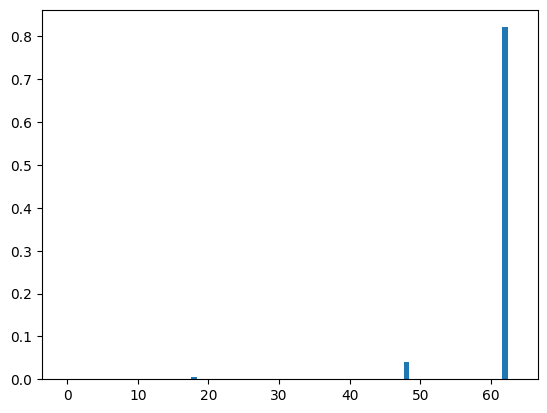

In [12]:
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

loader = valid_loader.__iter__()
images, labels = next(loader)

model.eval()
with torch.no_grad():
  outputs = model(images.to(device)).cpu()

# エントロピーを計算
entropy = calculate_entropy(outputs)
print("Label Entropy for each sample in the batch:", entropy)

ent = []
for e in entropy.tolist():
  ent.append([e, 0])

plt.bar(range(len(entropy)), entropy.numpy())
# plt.ylim(0, 1.5)
print(entropy.mean())

# ランダムデータのエントロピーを計算

ent tensor([8.8627e-02, 1.7144e-04, 3.1972e-04, 1.2532e+00, 9.5456e-01, 7.9263e-01,
        7.6258e-01, 2.7074e-01, 5.3986e-01, 1.9311e-01, 1.6532e+00, 1.2048e-01,
        3.3248e-05, 9.9005e-01, 5.0550e-01, 5.3719e-01, 8.0119e-08, 5.0544e-03,
        3.7069e-03, 1.3364e+00, 2.5910e-01, 1.8517e+00, 1.0342e+00, 1.3160e+00,
        1.1199e+00, 4.6765e-01, 3.4449e-01, 5.6758e-01, 1.1605e-04, 1.4951e+00,
        4.4362e-04, 7.0170e-05, 1.0404e+00, 3.1421e-01, 6.6329e-01, 3.0262e-03,
        1.8558e-02, 1.8538e-01, 2.7768e-01, 5.2369e-02, 7.5012e-05, 5.6532e-03,
        9.9235e-01, 1.8432e-02, 1.1737e+00, 4.6286e-06, 4.7344e-01, 3.2983e-01,
        5.9948e-01, 1.2796e+00, 4.6069e-01, 1.5250e+00, 3.8063e-02, 1.9999e-03,
        2.4177e-01, 1.9766e-02, 3.3161e-01, 5.4935e-01, 2.9896e-02, 2.2388e-02,
        4.7632e-01, 3.3696e-03, 7.8112e-03, 2.2310e-02])
Label Entropy for each sample in the batch: tensor([8.8627e-02, 1.7144e-04, 3.1972e-04, 1.2532e+00, 9.5456e-01, 7.9263e-01,
        7.6258e

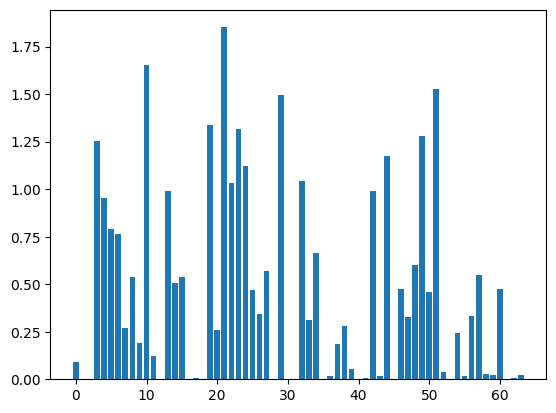

In [13]:
noise = torch.randn(images.shape)

model.eval()
with torch.no_grad():
  outputs = model(noise.to(device)).cpu()

# エントロピーを計算
entropy = calculate_entropy(outputs)
print("Label Entropy for each sample in the batch:", entropy)

for e in entropy.tolist():
  ent.append([e, 1])

plt.bar(range(len(entropy)), entropy.numpy())
# plt.ylim(0, 1.5)
print(entropy.mean())

In [14]:
ent.sort()
for val, sel in ent:
  print(sel, ":",  val)

0 : 1.4397987798414765e-15
0 : 1.8694206881282593e-14
0 : 1.965096278245832e-14
0 : 6.398483495427196e-14
0 : 8.42344247196751e-14
0 : 8.796188468362595e-14
0 : 4.072558533897014e-13
0 : 1.460741141760813e-12
0 : 2.1877430422811983e-12
0 : 2.6758228879181223e-12
0 : 1.6119876267151056e-11
0 : 3.251878280541298e-11
0 : 4.4373140578590764e-11
0 : 9.03667488061366e-11
0 : 1.0491833096759606e-10
0 : 1.1842539449080647e-10
0 : 1.289887863187289e-09
0 : 1.643901903491951e-09
0 : 2.1143995443395625e-09
0 : 8.61800941720503e-09
0 : 1.2429514306688816e-08
0 : 1.3408486765342786e-08
0 : 1.8368734089335703e-08
0 : 2.1639149139218716e-08
0 : 2.4494511308148503e-08
0 : 3.308353768716188e-08
0 : 3.898614053809979e-08
0 : 4.052600388604333e-08
0 : 4.483288051915224e-08
0 : 5.3041194547631676e-08
0 : 5.504172762016424e-08
0 : 6.655741913164093e-08
0 : 7.143655977870367e-08
1 : 8.011910068717043e-08
0 : 1.0623269020015869e-07
0 : 1.289848370333857e-07
0 : 1.5738694969513745e-07
0 : 2.682071453818935e-0